# FC Classification
1. Prepare Xy
2. fit a simple SVM classifier

In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import skopt
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import (SelectFromModel, SelectKBest,
                                       VarianceThreshold, f_classif, SelectPercentile,
                                       mutual_info_classif)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
# from umap import UMAP
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, 
                                     ShuffleSplit, StratifiedShuffleSplit, StratifiedGroupKFold,
                                     GroupShuffleSplit, cross_validate, cross_val_score, KFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real
from tqdm import tqdm

# import shap

# useful functions
def _patch_brain():
    brain_areas = {
                    'LF': ['Fp1', 'F3', 'F7', 'AF3', 'F1', 'F5', 'FT7'],
                    'LC': ['C3', 'T7', 'FC1', 'FC3', 'FC5', 'C1', 'C5'],
                    'LP': ['P3', 'P7', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P5'],
                    'LO': ['O1', 'PO3'],
                    'RF': ['Fp2', 'F4', 'F8', 'AF4', 'F2', 'F6', 'FT8'],
                    'RC': ['C4', 'T8', 'FC2', 'FC4', 'FC6', 'C2', 'C6'],
                    'RP': ['P4', 'P8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P6'],
                    'RO': ['O2', 'PO4'],
                    'FZ': ['Fpz', 'Fz'],
                    'CZ': ['Cz', 'CPz', 'FCz'],
                    'PZ': ['Pz', 'POz'],
                    'OZ': ['Oz', 'Iz']
        }
    return brain_areas


def _make_montage(path='data/raw/plb-hyp-live2131111.vhdr'):
    """
    Create a montage from barin vision raw data

    Parameters
    ----------
    path : str
        path to barinvision data header file

    """
    import copy
    raw = mne.io.read_raw_brainvision(path, verbose=False, misc=['ECG'])
    raw.crop(1, 10)  # crop a small segment of the data to speed up data loading in next lines
    raw.load_data().set_channel_types({'ECG': 'ecg'})
    # raw.add_reference_channels('FCz')  # FCz was used as online reference
    ch_names = copy.deepcopy(raw.info['ch_names'])  # make a deep copy of the lists of the
    # channel names otherwise ecg channel will be removed in the raw object!!
    ch_names.remove('ECG')

    pos_array = raw._get_channel_positions()

    # # add FCz position based on channels CPz (Their positions are the same, only y-axis value is different)
    # pos_fcz = pos_array[ch_names.index('CPz')] * np.array([1, -1, 1])
    # pos_array = np.insert(pos_array, 60, pos_fcz, axis=0)
    # pos_array = np.delete(pos_array, -1, axis=0)

    pos_dict = dict(zip(ch_names, pos_array))
    pos = mne.channels.make_dig_montage(pos_dict)

    return pos

# # add the hypnotizability data
# hypnotizability = pd.read_excel('data/PLB_HYP_data_MASTER.xlsx', index_col=0)
# hypnotizability = hypnotizability['hypnotizability_total'].iloc[9:59]
# DATA['hypnotizability_total'] = hypnotizability.repeat(4).reset_index(drop=True)
# # drop rows with nan values
# DATA = DATA.dropna(axis=0, how='any').reset_index(drop=True)

# FEATURE LABELS
# drop self-connections
yeo7 = {
    'N1': 'Visual',
    'N2': 'Somatomotor',
    'N3': 'DorsalAttention',
    'N4': 'VentralAttention',
    'N5': 'Limbic',
    'N6': 'Frontoparietal',
    'N7': 'Default',
    'mwall': 'Medial_Wall',
}

hemisferes = ['lh', 'rh']

freqs = ['theta', 'alpha', 'beta', 'lowgamma']

# labels based on Yeo2011 atlas orders
labels = [yeo7[k]+'_'+ hemisferes[i] for k in yeo7.keys() for i in range(len(hemisferes))]

conn_labels = pd.DataFrame(columns=labels, index=labels)
conn_labels = conn_labels.apply(lambda x: x.index + ' \N{left right arrow} ' + x.name)
conn_labels = conn_labels.values[np.triu_indices(conn_labels.shape[0], k=0)]

# self connections
identicals_col = [f'{i} \N{left right arrow} {i}' for i in labels]
id_col = [f'{i} ({j})' for i in identicals_col for j in freqs]


## Prepare Xy

In [10]:
# read data
DATA = pd.read_csv('data/classification_datasets/power_sensor.csv', index_col=0)

DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('condition.str.contains("experience")')
# DATA = DATA.query('procedure == "confusion" or procedure == "relaxation"')

# DATA.drop(id_col, axis=1, inplace=True) # drop self connections

#Xy
X = DATA.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session', 'condition',
                       'bids_id'])

col_name = [col for col in X.columns if 'beta' in col]
X = X[col_name]

y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1)
y.value_counts(normalize=True)

1    0.572816
0    0.427184
Name: hypnosis_depth, dtype: float64

In [37]:
# cross validation strategies
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100)

pipe = Pipeline([
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    # ('selectper', SelectPercentile(mutual_info_classif, percentile=80)),
    ('select', SelectFromModel(SVC(kernel='linear'), threshold=.001)),
    # ('reduce', PCA(n_components=30)),
    ('clf', SVC(kernel="linear", max_iter=-1, probability=True)),
    # ('clf', DummyClassifier(strategy='most_frequent'))
    # ('clf', RandomForestClassifier(n_estimators=100))
    # ('clf', AdaBoostClassifier(n_estimators=100))
])

# computing cross valided scores with multiple metric evaluation
scoring = ['accuracy']

# scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_estimator=True)
# scores['test_balanced_accuracy'].mean()
scores_total = []
for i in range(100):
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True).split(X, y, groups=DATA['bids_id'])
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)['test_accuracy']
    scores_total.append(scores)
scores_total = np.hstack(np.array(scores_total))
scores_total.mean(), scores_total.std()
# [f'{i}: mean = {scores[i].mean()}, std = {scores[i].std()}' for i in scores.keys()]

(0.5878853953064479, 0.11779329773171074)

In [ ]:
# Check classification accuracy for each class separately.
arrs = []
for i in range(1000):
    X_test, X_train, y_test, y_train = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model.score(X_test, y_test)
    df = pd.concat(
        [y_test,
        pd.DataFrame(y_pred, columns=['predicted'], index=y_test.index)],
        axis=1).reset_index(drop=True)

    df['correct'] = df.apply(lambda x: True if x['predicted'] == x['hypnosis_depth'] else False, axis=1)
    arr = df.groupby('hypnosis_depth').agg({'correct': 'mean'}).values
    arrs.append(arr)
np.array(arrs).mean(axis=0)

## Randomized Search with nested CV

In [74]:
import scipy
NUM_TRIALS = 2
nested_scores = []
best_estimators = []
importances = []
test_accuraies = []

# Set up possible values of parameters to optimize over

p_distributions = {'clf__C': scipy.stats.expon(scale=100),
                   'clf__gamma': scipy.stats.expon(scale=.1),
                #    'clf__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                #    'clf__degree': scipy.stats.randint(1, 10),
                   'reduce__n_components': scipy.stats.randint(1, 20),
                   }

# We will use a Support Vector Classifier with "rbf" kernel
pipe = Pipeline([
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('reduce', PCA()),
    ('clf', SVC(kernel="linear", max_iter=-1, probability=True)),
])
# Loop for each trial
for i in tqdm(range(NUM_TRIALS)):

    # Choose cross-validation techniques for the inner and outer loops,
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=i)
    
    for train, test in outer_cv.split(X, y, groups=DATA['bids_id']):

        # Nested CV with parameter optimization
        clf = RandomizedSearchCV(pipe, param_distributions=p_distributions, n_iter=100,
                                cv=inner_cv, n_jobs=-1,
                                scoring='balanced_accuracy', error_score=0)
        clf.fit(X.iloc[train], y.iloc[train])
        best_estimators.append(clf.best_params_)
        nested_scores.append(clf.best_score_)
        y_pred = clf.predict(X.iloc[test])
        test_accuraies.append((y.iloc[test] == y_pred).mean())
        
        # perm_imp_results = permutation_importance(
        #     clf.best_estimator_, X.iloc[test], y.iloc[test], scoring='balanced_accuracy', n_repeats=30, n_jobs=-1)
        # importances.append(perm_imp_results['importances'])
        
    # nested_score = cross_validate(clf, X=X, y=y, cv=outer_cv, scoring=['balanced_accuracy'],
    #                               return_estimator=True)
#     nested_scores.append(nested_score['test_balanced_accuracy'])
# np.hstack(np.array(nested_scores)).mean()
C = np.array([best_estimators[i]['clf__C'] for i in range(len(best_estimators))]).mean()
gamma = np.array([best_estimators[i]['clf__gamma'] for i in range(len(best_estimators))]).mean()
n_component = round(np.array([best_estimators[i]['reduce__n_components'] for i in range(len(best_estimators))]).mean())
np.array(nested_scores).mean()

100%|██████████| 2/2 [19:33<00:00, 586.82s/it]


0.679861138861139

In [78]:
C, gamma, n_component

(58.479318522248114, 0.08828353759508438, 14)

### BayesSearch

In [ ]:
opt = BayesSearchCV(
    pipe,
    search_spaces={'clf__C': (0.01, 100.0, 'log-uniform'),
                   'clf__gamma': (0.001, 0.1, 'log-uniform'),},
    n_iter=1000,
    cv=5
)

opt.fit(X,
        y, 
        callback=[skopt.callbacks.DeadlineStopper(total_time=60*10)]
        )

pipe = opt.best_estimator_
scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
[f'{i}: mean = {scores[i].mean()}, std = {scores[i].std()}' for i in scores.keys()]

### Permutation test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


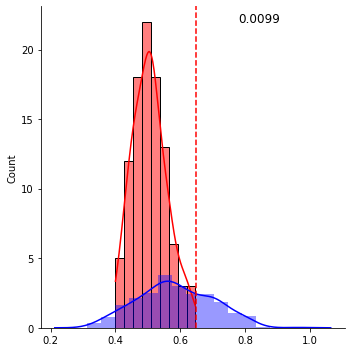

In [100]:
# permutation test
from sklearn.model_selection import permutation_test_score
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

# TODO why the score on the permuted sample is lower than baseline 
obs_score, perm_socres, p_value = permutation_test_score(
    pipe, X, y, cv=cv, scoring='balanced_accuracy', n_permutations=100, n_jobs=-1, verbose=3)

sns.displot(perm_socres, kde=True, color='red')
sns.distplot(scores_total, kde=True, color='blue')
plt.axvline(obs_score, color='r', linestyle='--')
plt.annotate(f'{p_value:.4f}', xy=(obs_score, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

In [ ]:
# bootstrap confidence interval
np.random.choice(scores, size=1000, replace=True).mean()

## Permutation Importance
Some of the results of my experiment:

First, I did permutation importance considering all 1770 features **(test_accuracy = 0.75)**

Using only the top five important features in my model yeilds still a significantly better performance than chance. **(test_accuracy = 0.66)**

Using the least five important feature yeilds terrible result: the distribution of scores is in quite overlap with the permuted scores. **(test_accuracy = 0.54)**

Using the top 200 important features in my model yeilds the best performance **(test_accuracy = 0.78)**

Taking all the features with positive, non-zero importance into account (n=984) won't change the model performance that much **(test_accuracy = 0.77)**

The best performance **(test_accuracy = 0.80)** , though with relatively high (=0.057) was achieved when the importance of included features were equal or higher than 0.00125.

On the contrary, when these exact features (the top 350 important features) were excluded, model's performance dropped drastically down to **0.60**

Next step was to do the permutation feature importance with the winner model: in this round, some features show a mean importance as high as 0.05, in contrast to the first round when the mean importance of the top feature was only 0.006! (This observation is definitely due to the stolen variance by those unimportant features in the first run!)

As running the permutation importance code was incredibly faster this time, we increased the number of repetation and our top feature got a mean importance of 0.08! The test accuracy this time was as high as **0.82** (By BayesianGrid search (n_iter=500, cv=5, callback time=5 min) test accuracy increased to **0.85**, std = 0.03858612300930076') But with each run of cross_validate() the acuuracy and std would differ, but it won't get lower than 0.8.

Problem of **data leakage**: when I only took the experience part of the data, the accuracy fell to **0.74** with a higher std (0.09), but this result was still beat the permuted classifier! (using only half of the data did not have such a effect (acc = 0.8 on first haf, 0.78 on second half)! so lower accuracy is not because of the smaller data) interestingly, in the permutation test, p_value is 0.3 when we use only the second half of the data and 0.01 when we use the first half. P_value remains 0.0099 when we only include the experience parts.

Dropping self conncetions and connections to M1 and M2 gave as an accuracy of 0.75 and std = 0.05.

The performance of the model with the aggregate connections across different brain areas was 0.62, std = 0.07 and scores' distribution had two peaks. That shows us one thing: by aggregating features we actually loose information and that highlights the importance of techniques that can handle high dimentionality.

Using real hypnosis with 252 most important features (described as hypnosis or not) the accuracy is **0.7**, and std = 0.06. taking only experience, or induction rows into account, classification performance is really poor: 0.6.

**Regression** I used SVR with the data from the conditions presented as hypnosis to participants, and doing BayesianSearch I got explained_variance = 0.21 and r2=0.20. Bayesian search gave us C=37.62399869785873, and gamma=0.01033864984323087.


# TODO compare the baseline of the hypnotizable and the non-hypnotizable.

In [174]:
from sklearn.inspection import permutation_importance
cv = StratifiedGroupKFold(n_splits=5, shuffle=True)
importances = []
for i in tqdm(range(30)):
    for train, test in cv.split(X, y, groups=DATA['bids_id']):
        pipe.fit(X.iloc[train], y.iloc[train])
        perm_imp_results = permutation_importance(
            pipe, X.iloc[test], y.iloc[test], scoring='accuracy', n_repeats=20, n_jobs=-1)
        importances.append(perm_imp_results['importances'])


100%|██████████| 30/30 [02:22<00:00,  4.74s/it]


In [176]:
imp_df = pd.DataFrame(np.hstack(importances), index=X.columns)
imp_df.reset_index(inplace=True)
imp_df = imp_df.melt(id_vars=['index'])
imp_df.rename(columns={'index': 'feature', 'value': 'importance', 'variable': 'repetition'}, inplace=True)
imp_df['mean_importance'] = imp_df.groupby('feature')['importance'].transform('mean')
imp_df.sort_values(by='mean_importance', ascending=False, inplace=True)

# fig, ax = plt.subplots(figsize=(20, 5))
# # sns.barplot(x='importance', y='feature', data=imp_df1, orient='h', ax=ax, )
# sns.lineplot(x='feature', y='importance', data=imp_df1, ax=ax, ci=95)
# sns.scatterplot(x='feature', y='mean_importance', data=imp_df1, ax=ax)
# plt.xticks(rotation=45, fontsize='small', rotation_mode='anchor', ha='right')
# plt.xlabel('feature', fontsize='xx-large')
# plt.ylabel('importance', fontsize='xx-large')
# plt.suptitle('Permutation Importance', fontsize='xx-large')
# plt.show()

Text(0, 0.5, 'Feature name')

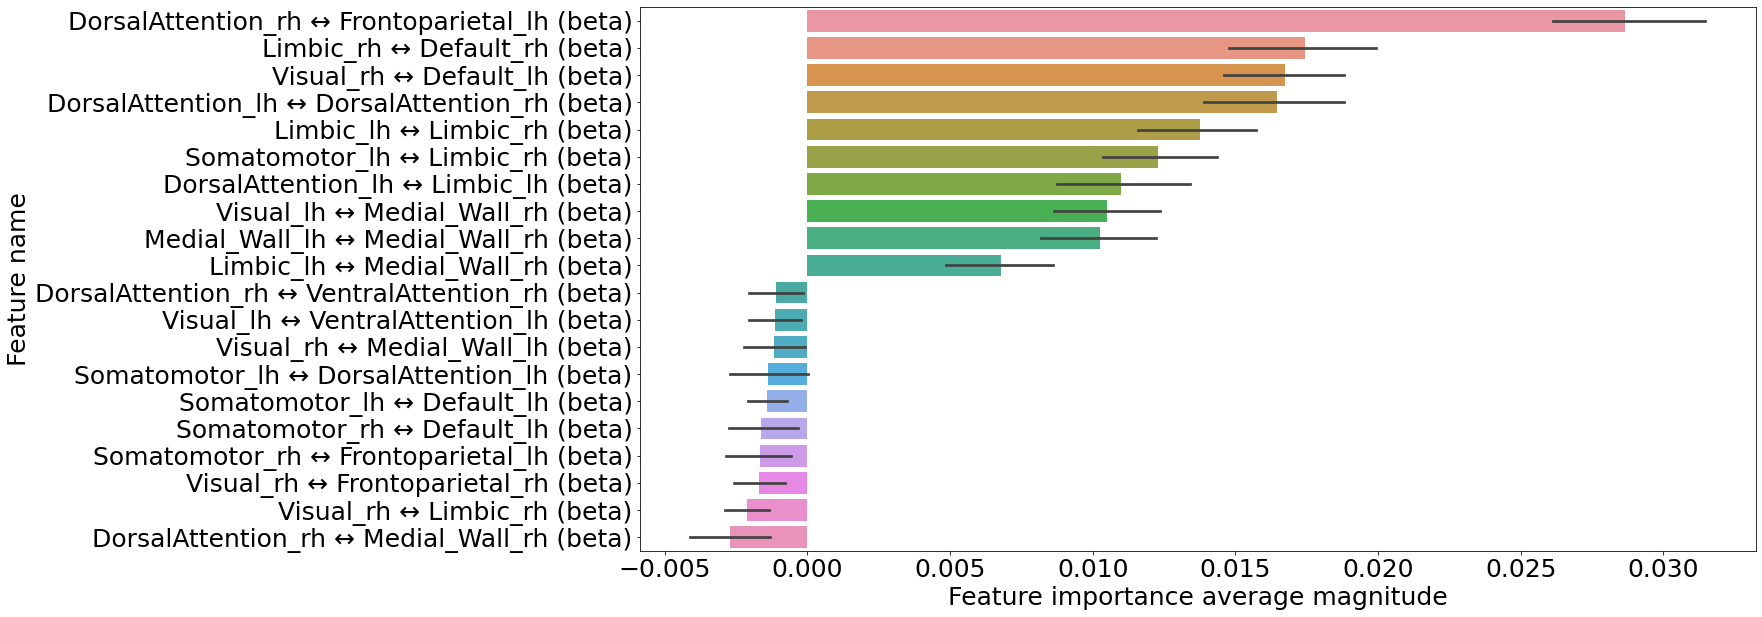

In [178]:
imp_df3 = imp_df.sort_values('mean_importance', ascending=False)[:30000]
imp_df2 = imp_df.sort_values('mean_importance', ascending=False)[-30000:]
df = pd.concat([imp_df3, imp_df2])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x='importance', y='feature', data=df, orient='h', ax=ax)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Feature importance average magnitude', fontsize=25)
plt.ylabel('Feature name', fontsize=25)
# plt.title('Permutation Importance', fontsize='xx-large')

## Comparing conditions (baseline vs. experience)

### Xy

In [31]:
# read data
DATA = pd.read_csv('data/classification_datasets/connectivities_yeo7nets_others.csv', index_col=0)

DATA = DATA.query('condition == "baseline2" or description == "hypnosis"')

DATA = DATA.query('procedure == "confusion" or procedure == "relaxation" or condition == "baseline2"')

#Xy
X = DATA.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session', 'condition',
                       'bids_id'])

col_name = [col for col in X.columns if 'theta' in col]
X = X[col_name]

y = DATA['condition'].apply(lambda x: 'baseline' if x == 'baseline2' else 'experinece')
y.value_counts()

baseline      52
experinece    51
Name: condition, dtype: int64

In [32]:
pipe = Pipeline([
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    # ('selectper', SelectPercentile(mutual_info_classif, percentile=80)),
    ('select', SelectFromModel(SVC(kernel='linear'))),
    # ('reduce', PCA(n_components=10)),
    ('clf', SVC(kernel="linear", max_iter=-1, probability=True)),
    # ('clf', DummyClassifier(strategy='most_frequent'))
    # ('clf', RandomForestClassifier(n_estimators=100))
])

# computing cross valided scores with multiple metric evaluation
scoring = ['accuracy']

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100)
# scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_estimator=True)
# scores['test_balanced_accuracy'].mean()
scores_total = []
for i in range(100):
    # cross validation strategies
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True).split(X, y, groups=DATA['bids_id'])
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)['test_accuracy']
    scores_total.append(scores)
scores_total = np.hstack(np.array(scores_total))
scores_total.mean(), scores_total.std()

(0.6226554112554112, 0.10490362890819356)

/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


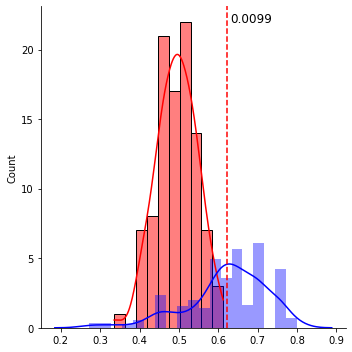

In [66]:
# permutation test
from sklearn.model_selection import permutation_test_score
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

# TODO why the score on the permuted sample is lower than baseline 
obs_score, perm_socres, p_value = permutation_test_score(
    pipe, X, y, cv=cv, scoring='balanced_accuracy', n_permutations=100, n_jobs=-1, verbose=0)

sns.displot(perm_socres, kde=True, color='red')
sns.distplot(scores_total, kde=True, color='blue')
plt.axvline(obs_score, color='r', linestyle='--')
plt.annotate(f'{p_value:.4f}', xy=(obs_score, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

## Baseline Correction

In [29]:
# read and modify data
DATA = pd.read_csv('data/classification_datasets/connectivities_yeo7nets_others.csv', index_col=0)

DATA = DATA.query('condition == "baseline2" or description == "hypnosis"')

DATA.drop(id_col, axis=1, inplace=True) # drop identical columns

#Xy
X = DATA.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session'])

# normalize data
def normalize_connectivities(df):
    df.set_index('condition', inplace=True)
    baseline = df.loc['baseline2']
    df = df.apply(lambda x: x/baseline, axis=1)
    return df
   
X = X.groupby('bids_id').apply(normalize_connectivities)
X = X.drop(columns='bids_id')
X = X.query('condition != "baseline2"')
X = X.reset_index().sort_values(['bids_id', 'condition']).drop(columns=['condition', 'bids_id'])

col_name = [col for col in X.columns if 'gamma' in col]
X = X[col_name]

DATA = DATA.query('condition != "baseline2"').reset_index()
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1)
y.value_counts(normalize=True)

1    0.572816
0    0.427184
Name: hypnosis_depth, dtype: float64

In [30]:
pipe = Pipeline([
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    # ('selectper', SelectPercentile(mutual_info_classif, percentile=80)),
    ('select', SelectFromModel(SVC(kernel='linear'))),
    # ('reduce', PCA(n_components=10)),
    ('clf', SVC(kernel="linear", max_iter=-1, probability=True)),
    # ('clf', DummyClassifier(strategy='most_frequent'))
    # ('clf', RandomForestClassifier(n_estimators=100))
])

# computing cross valided scores with multiple metric evaluation
scoring = ['accuracy']

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100)
# scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_estimator=True)
# scores['test_balanced_accuracy'].mean()
scores_total = []
for i in range(100):
    # cross validation strategies
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True).split(X, y, groups=DATA['bids_id'])
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)['test_accuracy']
    scores_total.append(scores)
scores_total = np.hstack(np.array(scores_total))
scores_total.mean(), scores_total.std()

(0.546751424014582, 0.11450775797892104)

## SHAP

In [ ]:
import shap

shap_values_cv = []
X_test_indexes_cv = []
y_test_cv = []
y_pred_cv = []

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
pca = PCA(n_components=pipe.named_steps['reduce'].n_components_)

for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    X_train_reduced = pca.fit_transform(X.iloc[train])
    X_test_reduced = pca.fit_transform(X.iloc[test])
    pipe.fit(X.iloc[train], y.iloc[train])
    y_pred = pipe.predict(X.iloc[test])
    # TODO: check if model is a treebased one, otherwise use shap.Explainer and clf.predict_proba
    # for treebased models, use TreeExplainer and clf.named_steps['clf']
    explainer = shap.KernelExplainer(pipe.named_steps['clf'].predict_proba, data=X_train_reduced,
                                   output_names=pipe.named_steps['clf'].classes_)
    _shap_values = explainer.shap_values(X_test_reduced)
    shap_values_cv.append(_shap_values)
    X_test_indexes_cv.append(test)
    y_test_cv.append(y.iloc[test])
    y_pred_cv.append(y_pred)

In [ ]:
# merge shap_values_cv into a single shap values array

X_test = X.iloc[np.hstack(X_test_indexes_cv)]
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)

shap_values = shap.Explanation(
    values=np.vstack([sh.values for sh in shap_values_cv]),
    base_values=np.vstack([sh.base_values for sh in shap_values_cv]),
    data=np.vstack([sh.data for sh in shap_values_cv]),
    feature_names=shap_values_cv[0].feature_names,
    output_names=shap_values_cv[0].output_names,
    output_indexes=y_pred
)